In [17]:
from data import random_sequence
from phylo import *
from scipy.linalg import expm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

# Stationary

In [18]:
pi = np.array([.1, .2, .3, .4])
piA, piG, piC, piT = pi
mutation_rate = 1e-8
a, b, c, d, e, f = mutation_rate*np.array([1, 2, 3, 4, 5, 6])
Q = np.array([[0,     a*piG, b*piC, c*piT],
              [a*piA, 0,     d*piC, e*piT],
              [b*piA, d*piG, 0,     f*piT],
              [c*piA, e*piG, f*piC, 0    ]])
np.fill_diagonal(Q, -np.sum(Q, 1))

In [19]:
print('Overall substitution rate: %.2e' % -np.dot(pi, np.diag(Q)))

Overall substitution rate: 3.12e-08


In [20]:
sequence_length = 10000
sequence = random_sequence(sequence_length, pi)
T = 1e8
dt = 1e3

In [21]:
def mutate(sequence, P):
    substitutions = np.zeros((4, 4))
    new_sequence = np.zeros(sequence.shape)
    for i in range(4):
        probs = P[i, :]
        inds = sequence==i
        new_nucleotides = np.random.choice(4, np.sum(inds), p=probs)
        new_sequence[inds] = new_nucleotides
    for i in range(4):
        for j in range(4):
            ij_subs = (sequence==i) & (new_sequence==j)
            substitutions[i, j] = int(np.sum(ij_subs))
    return new_sequence, substitutions

In [22]:
ngen = int(T/dt)
all_subs = np.zeros((4, 4, ngen))
P = expm(dt*Q)
for i in range(ngen):
    sequence, substitutions = mutate(sequence, P)
    all_subs[:, :, i] = substitutions

In [23]:
all_subs[:,:,0].astype(np.int)

array([[ 988,    0,    0,    0],
       [   0, 1955,    0,    0],
       [   0,    0, 2932,    0],
       [   0,    0,    0, 4125]])

In [24]:
num_subs = np.cumsum(all_subs, axis=2)

In [25]:
num_subs[:, :, -1].astype(int)

array([[103449559,       202,       577,      1189],
       [      218, 199238353,      2388,      3996],
       [      612,      2311, 295242019,      7083],
       [     1216,      4109,      7075, 402039093]])

In [26]:
Q0 = Q.copy()
np.fill_diagonal(Q0, np.zeros(4))
#rates = np.dot(pi, Q0)
rates = -np.diag(Q)*pi

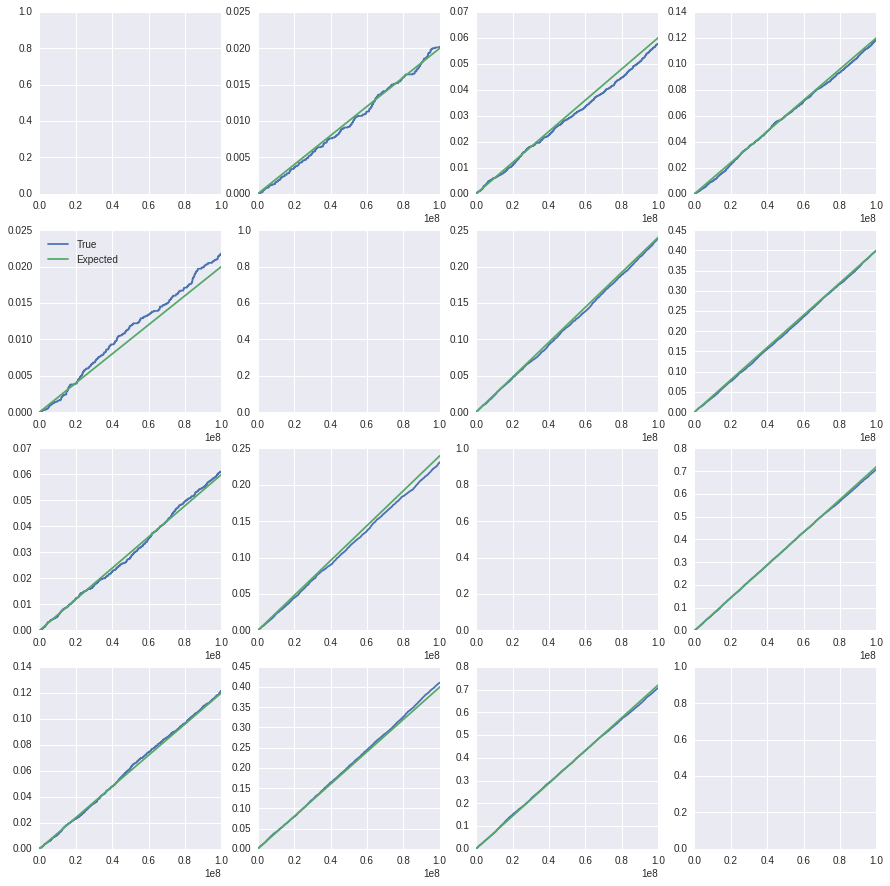

In [27]:
t = np.linspace(0, T, ngen)
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    for j in range(4):
        if i != j:
            axs[i,j].plot(t, num_subs[i,j,:]/sequence_length, label='True')
            axs[i,j].plot(t, pi[i]*Q[i,j]*t, label='Expected')
axs[1, 0].legend(loc='upper left')
plt.show()

# Non-stationary

In [28]:
ngen = int(T/dt)
all_subs = np.zeros((4, 4, ngen))
P = expm(dt*Q)
piR = np.array([.4, .3, .2, .1])
sequence = random_sequence(sequence_length, piR)
for i in range(ngen):
    sequence, substitutions = mutate(sequence, P)
    all_subs[:, :, i] = substitutions

In [29]:
num_subs = np.cumsum(all_subs, axis=2)

In [30]:
L, U = np.linalg.eig(Q)
V = np.linalg.inv(U)
QQ = np.dot(np.dot(U, L), V)
np.linalg.norm(Q-QQ)

1.6300056464874989e-07

In [31]:
ngen

100000

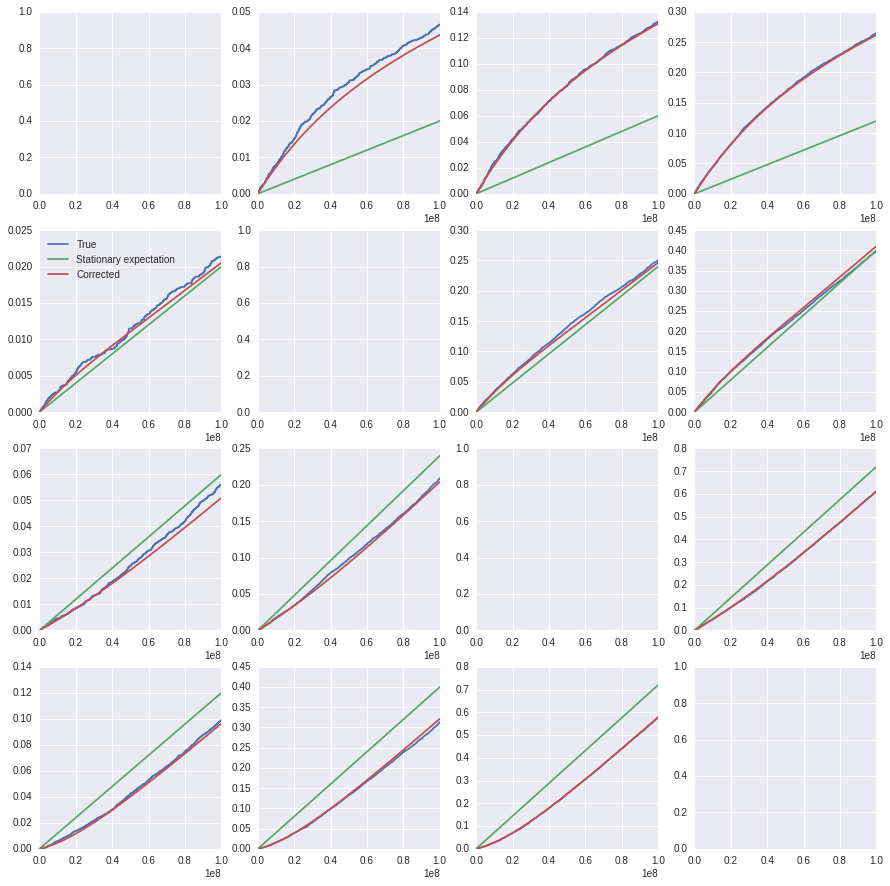

In [32]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
k = 4
l = 4
m = ngen

for i in range(4):
    for j in range(4):
        if i != j:
            I = np.zeros((l, m))
            I[0, :] = t
            I[1:, :] = (np.exp(t[None,:]*L[1:,None])-1)/L[1:,None]
            v = V[:, i]
            big_tensor = ((I[None, :, :] * U[:, :, None]) * piR[:, None, None])  * v[None, :, None]
            correct_subs = Q[i, j]*np.sum(big_tensor, (0, 1))

            axs[i, j].plot(t, num_subs[i, j,:]/sequence_length, label='True')
            axs[i, j].plot(t, pi[i]*Q[i, j]*t, label='Stationary expectation')
            axs[i, j].plot(t, correct_subs, label='Corrected')
axs[1, 0].legend(loc='upper left')
plt.show()